STAKEHOLDER: Leading Telecommunications Company

PROBLEM: The stakeholder has approached up to find out how they can reduce churn.

BUSINESS UNDERSTADING: Build a classifier to predict whether a customer will ("soon") stop doing business with our stakeholder. Optimize to reduce amount of money lost due to churn. This is a binary classification problem.

## EDA

Import libraries

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, NearestNeighbors
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, f1_score, plot_roc_curve, classification_report, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier, StackingRegressor
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline
from statsmodels.api import qqplot
from scipy import stats

Load and explore dataset

In [16]:
df = pd.read_csv('data/cell2celltrain.csv')
df.head()

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,0,9,No,1,10,No,1-Highest,Other,Professional,Yes


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51047 entries, 0 to 51046
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 51047 non-null  int64  
 1   Churn                      51047 non-null  object 
 2   MonthlyRevenue             50891 non-null  float64
 3   MonthlyMinutes             50891 non-null  float64
 4   TotalRecurringCharge       50891 non-null  float64
 5   DirectorAssistedCalls      50891 non-null  float64
 6   OverageMinutes             50891 non-null  float64
 7   RoamingCalls               50891 non-null  float64
 8   PercChangeMinutes          50680 non-null  float64
 9   PercChangeRevenues         50680 non-null  float64
 10  DroppedCalls               51047 non-null  float64
 11  BlockedCalls               51047 non-null  float64
 12  UnansweredCalls            51047 non-null  float64
 13  CustomerCareCalls          51047 non-null  flo

In [18]:
df.describe()

,CustomerID,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,...,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,RetentionCalls,RetentionOffersAccepted,ReferralsMadeBySubscriber,IncomeGroup,AdjustmentsToCreditRating
count,5.104700e+04,50891.000000,50891.000000,50891.000000,50891.000000,50891.000000,50891.000000,50680.000000,50680.000000,51047.000000,...,51046.000000,51046.000000,51046.000000,50138.000000,50138.000000,51047.000000,51047.000000,51047.000000,51047.000000,51047.000000
mean,3.201957e+06,58.834492,525.653416,46.830088,0.895229,40.027785,1.236244,-11.547908,-1.191985,6.011489,...,1.805646,1.558751,380.545841,31.338127,21.144142,0.037201,0.018277,0.052070,4.324524,0.053911
std,1.169056e+05,44.507336,529.871063,23.848871,2.228546,96.588076,9.818294,257.514772,39.574915,9.043955,...,1.331173,0.905932,253.801982,22.094635,23.931368,0.206483,0.142458,0.307592,3.138236,0.383147
min,3.000002e+06,-6.170000,0.000000,-11.000000,0.000000,0.000000,0.000000,-3875.000000,-1107.700000,0.000000,...,1.000000,1.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.100632e+06,33.610000,158.000000,30.000000,0.000000,0.000000,0.000000,-83.000000,-7.100000,0.700000,...,1.000000,1.000000,205.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.201534e+06,48.460000,366.000000,45.000000,0.250000,3.000000,0.000000,-5.000000,-0.300000,3.000000,...,1.000000,1.000000,329.000000,36.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000
75%,3.305376e+06,71.065000,723.000000,60.000000,0.990000,41.000000,0.300000,66.000000,1.600000,7.700000,...,2.000000,2.000000,515.000000,48.000000,42.000000,0.000000,0.000000,0.000000,7.000000,0.000000
max,3.399994e+06,1223.380000,7359.000000,400.000000,159.390000,4321.000000,1112.400000,5192.000000,2483.500000,221.700000,...,24.000000,15.000000,1812.000000,99.000000,99.000000,4.000000,3.000000,35.000000,9.000000,25.000000


## Cleaning

Dropped null values and eliminated unuseful columns

In [19]:
df.dropna(how='any', inplace=True)
df.drop(['CustomerID', 'Homeownership', 'NotNewCellphoneUser', 'HandsetPrice', 
         'PrizmCode', 'Occupation', 'MaritalStatus'], axis=1, inplace=True)

Replaced service area data with zip code 

In [20]:
df['ZipCode'] = df['ServiceArea'].str[-3:].astype(int)
df = df.drop('ServiceArea', axis=1)

Converted categorical strings to numeric data

In [21]:
df.replace(to_replace='Yes', value=1, inplace=True)
df.replace(to_replace='No', value=0, inplace=True)
df['CreditRating'] = (df['CreditRating'].str[0]).astype(int)

In [22]:
df

,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,...,RetentionCalls,RetentionOffersAccepted,NewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,MadeCallToRetentionTeam,CreditRating,ZipCode
0,1,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,0.7,...,1,0,0,0,4,0,0,1,1,503
1,1,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,0.3,...,0,0,1,0,5,0,0,0,4,412
2,0,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,0.0,...,0,0,1,0,6,0,0,0,3,414
3,0,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,52.0,...,0,0,1,0,6,0,0,0,4,412
4,1,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,0.0,...,0,0,0,0,9,0,1,0,1,918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51035,0,0.00,76.0,30.0,0.00,0.0,0.0,0.0,0.0,5.7,...,0,0,0,0,4,0,0,0,2,619
51037,0,31.92,63.0,17.0,0.00,43.0,0.0,-38.0,-13.2,0.7,...,0,0,0,0,3,0,0,0,3,760
51040,0,71.99,724.0,70.0,0.00,4.0,0.9,-40.0,-2.0,14.3,...,0,0,0,0,7,0,0,0,1,818
51041,1,117.49,384.0,30.0,0.00,250.0,0.0,0.0,0.0,4.0,...,0,0,0,0,2,0,0,0,5,562


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49752 entries, 0 to 51043
Data columns (total 51 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Churn                      49752 non-null  int64  
 1   MonthlyRevenue             49752 non-null  float64
 2   MonthlyMinutes             49752 non-null  float64
 3   TotalRecurringCharge       49752 non-null  float64
 4   DirectorAssistedCalls      49752 non-null  float64
 5   OverageMinutes             49752 non-null  float64
 6   RoamingCalls               49752 non-null  float64
 7   PercChangeMinutes          49752 non-null  float64
 8   PercChangeRevenues         49752 non-null  float64
 9   DroppedCalls               49752 non-null  float64
 10  BlockedCalls               49752 non-null  float64
 11  UnansweredCalls            49752 non-null  float64
 12  CustomerCareCalls          49752 non-null  float64
 13  ThreewayCalls              49752 non-null  flo

In [71]:
df.Churn.value_counts()

0    35507
1    14245
Name: Churn, dtype: int64

## Model Analysis

Assign x and y values, train_test_split, and scale data

In [37]:
x = df.drop('Churn', axis=1)
y = df.Churn
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=15)
scale = StandardScaler()
x_train_scaled = scale.fit_transform(x_train)
x_test_scaled = scale.transform(x_test)

LogReg

Train 0.04945054945054945
Test 0.05756535516239768


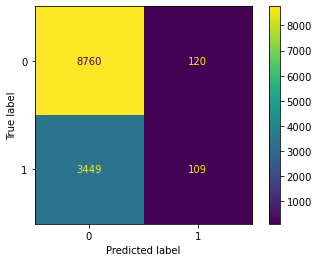

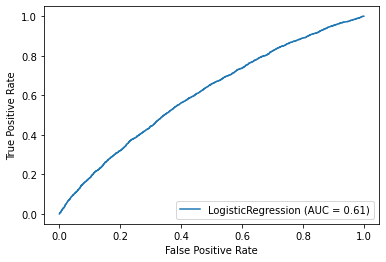

In [52]:
lr = LogisticRegression()
lr.fit(x_train_scaled, y_train)
y_hat_train = lr.predict(x_train_scaled)
y_hat_test = lr.predict(x_test_scaled)
print(f'Train {f1_score(y_train, y_hat_train)}')
print(f'Test {f1_score(y_test, y_hat_test)}')
plot_confusion_matrix(lr, x_test_scaled, y_test);
plot_roc_curve(lr, x_test_scaled, y_test);

KNN

Train 0.5849212014716381
Test 0.2631490505797345


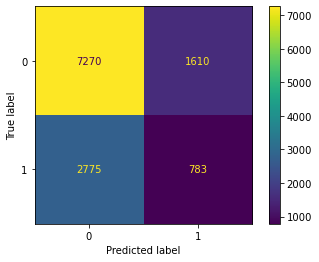

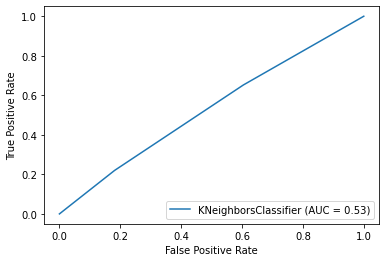

In [53]:
mscale = MinMaxScaler()
x_train_mscaled = mscale.fit_transform(x_train)
x_test_mscaled = mscale.transform(x_test)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train_mscaled, y_train)
y_hat_train = knn.predict(x_train_mscaled)
y_hat_test = knn.predict(x_test_mscaled)
print(f'Train {f1_score(y_train, y_hat_train)}')
print(f'Test {f1_score(y_test, y_hat_test)}')
plot_confusion_matrix(knn, x_test_mscaled, y_test);
plot_roc_curve(knn, x_test_mscaled, y_test);

Decision Trees

Train 0.9999064196144488
Test 0.35069105123551586


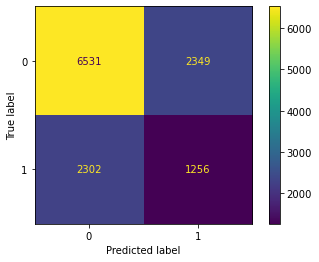

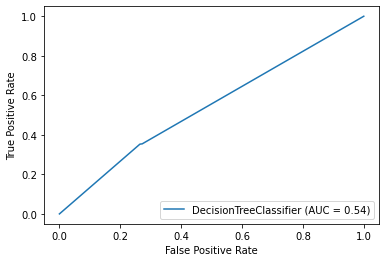

In [64]:
clf = DecisionTreeClassifier(min_impurity_decrease=.000003)
clf.fit(x_train_scaled, y_train)
y_hat_train = clf.predict(x_train_scaled)
y_hat_test = clf.predict(x_test_scaled)
print(f'Train {f1_score(y_train, y_hat_train)}')
print(f'Test {f1_score(y_test, y_hat_test)}')
plot_confusion_matrix(clf, x_test_scaled, y_test);
plot_roc_curve(clf, x_test_scaled, y_test);

Random Forest

Train 0.6922654294609608
Test 0.11981799797775532


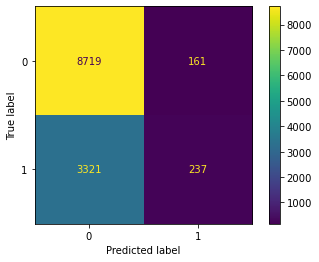

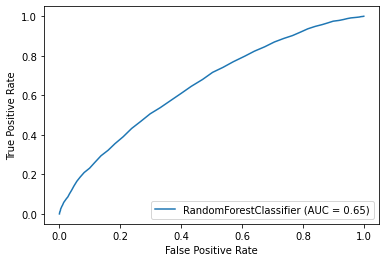

In [73]:
rfc = RandomForestClassifier(max_features='sqrt', max_samples=0.3)
rfc.fit(x_train_scaled, y_train)
scores = cross_val_score(estimator=rfc, X=x_train_scaled, y=y_train, cv=5)
y_hat_train = rfc.predict(x_train_scaled)
y_hat_test = rfc.predict(x_test_scaled)
print(f'Train {f1_score(y_train, y_hat_train)}')
print(f'Test {f1_score(y_test, y_hat_test)}')
plot_confusion_matrix(rfc, x_test_scaled, y_test);
plot_roc_curve(rfc, x_test_scaled, y_test);